## Where and When Should I Not Be Parking Illegally in NYC?

In [1]:
import os
import pandas as pd
import geopandas as gpd
import subprocess
from geopandas.tools import geocode
import re
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import statsmodels.formula.api as smf

%matplotlib inline
#%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120
#%matplotlib notebook

In [2]:
data_folder = '/Users/geoffperrin/Desktop/python_sandbox/NYPD/data'

### Read in NYPD parking data

In [3]:
'''
taken from:
https://data.cityofnewyork.us/Social-Services/nypd-7-major-felony-incidents/k384-xu3q/data
filtered to Agency: NYPD
Complaint Type: Illegal Parking
'''

nypd_df_raw = pd.read_csv(data_folder+'/nypd_7_major_felony_incidents.csv')
nypd_df = nypd_df_raw[['Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', \
                       'Community Board', 'Borough', 'Latitude', 'Longitude']]

#subset to just blocked sidewalks
nypd_df = nypd_df[nypd_df.Descriptor == "Blocked Sidewalk"]
nypd_df.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Created Date             Closed Date Agency   Complaint Type  \
9   09/04/2015 08:52:01 PM  09/04/2015 11:24:31 PM   NYPD  Illegal Parking   
37  09/04/2015 04:43:36 PM  09/04/2015 10:15:45 PM   NYPD  Illegal Parking   
46  09/04/2015 08:46:01 AM  09/04/2015 12:14:42 PM   NYPD  Illegal Parking   
54  09/05/2015 12:03:41 AM                     NaN   NYPD  Illegal Parking   
57  09/04/2015 07:17:15 PM  09/05/2015 02:51:48 AM   NYPD  Illegal Parking   

          Descriptor    Location Type   Community Board        Borough  \
9   Blocked Sidewalk  Street/Sidewalk         05 QUEENS         QUEENS   
37  Blocked Sidewalk  Street/Sidewalk  03 STATEN ISLAND  STATEN ISLAND   
46  Blocked Sidewalk  Street/Sidewalk  02 STATEN ISLAND  STATEN ISLAND   
54  Blocked Sidewalk  Street/Sidewalk     0 Unspecified    Unspecified   
57  Blocked Sidewalk  Street/Sidewalk       01 BROOKLYN       BROOKLYN   

     Latitude  Longitude  
9   40.722005 -73.904019  
37  40.562832 -74.148151  
46  40.593806 -74.075633  
54        NaN        NaN  
57  40.713757 -73.936055

In [4]:
nypd_df['create_date_time'] = pd.to_datetime(nypd_df['Created Date'])
nypd_df['closed_date_time'] = pd.to_datetime(nypd_df['Closed Date'])

In [5]:
nypd_df['create_date'] = nypd_df['create_date_time'].dt.date
nypd_df['day_of_week'] = nypd_df.create_date.apply(lambda x: x.weekday())

#control for Friday / Saturday nights
nypd_df['weekend'] = 0
nypd_df['weekend'][(nypd_df['day_of_week'] == 4) | (nypd_df['day_of_week'] == 5)] = 1

#control for hour of day
nypd_df['hour_of_day'] = nypd_df.create_date_time.apply(lambda x: x.hour)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
nypd_df.sort(['create_date_time']).head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


Created Date             Closed Date Agency  \
133642  06/03/2010 03:41:11 PM  06/03/2010 04:49:08 PM   NYPD   
133666  06/03/2010 04:09:26 PM  06/03/2010 04:23:23 PM   NYPD   
133653  06/03/2010 05:41:12 PM  06/04/2010 07:18:51 AM   NYPD   
133643  06/03/2010 07:14:56 PM  06/04/2010 12:21:08 AM   NYPD   
133768  06/04/2010 06:55:34 AM  06/04/2010 11:06:31 AM   NYPD   

         Complaint Type        Descriptor    Location Type   Community Board  \
133642  Illegal Parking  Blocked Sidewalk  Street/Sidewalk      05 MANHATTAN   
133666  Illegal Parking  Blocked Sidewalk  Street/Sidewalk      06 MANHATTAN   
133653  Illegal Parking  Blocked Sidewalk  Street/Sidewalk  01 STATEN ISLAND   
133643  Illegal Parking  Blocked Sidewalk  Street/Sidewalk      09 MANHATTAN   
133768  Illegal Parking  Blocked Sidewalk  Street/Sidewalk       18 BROOKLYN   

              Borough   Latitude  Longitude    create_date_time  \
133642      MANHATTAN  40.762334 -73.980370 2010-06-03 15:41:11   
133666      MANHATTAN  40.747629 -73.976736 2010-06-03 16:09:26   
133653  STATEN ISLAND  40.618095 -74.086207 2010-06-03 17:41:12   
133643      MANHATTAN  40.814067 -73.960362 2010-06-03 19:14:56   
133768       BROOKLYN  40.639118 -73.910998 2010-06-04 06:55:34   

          closed_date_time create_date  day_of_week  weekend  hour_of_day  
133642 2010-06-03 16:49:08  2010-06-03            3        0           15  
133666 2010-06-03 16:23:23  2010-06-03            3        0           16  
133653 2010-06-04 07:18:51  2010-06-03            3        0           17  
133643 2010-06-04 00:21:08  2010-06-03            3        0           19  
133768 2010-06-04 11:06:31  2010-06-04            4        1            6

### Time Series of Counts 

In [7]:
nypd_count_df = nypd_df.groupby(['create_date'], as_index=False)['Agency'].count()
nypd_count_df.columns = ['create_date', 'sidewalk_parking_count']

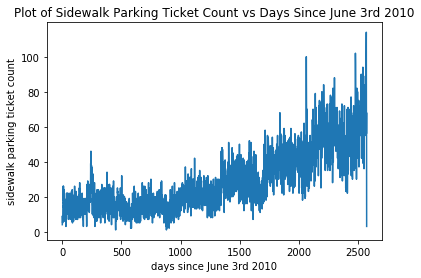

In [8]:
plt.plot(nypd_count_df[['sidewalk_parking_count']])
plt.xlabel('days since June 3rd 2010')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Days Since June 3rd 2010')

Note: I don't have a way to account for changes in vehicle counts across time, as I only have the ACS snapshot for 2015. However, since we are dealing with a relatively short 7 year period, I think it's safe to assume the vehicle count across the entire city is relatively constant across that time. With that assumption in place, we can see a gradual increase in the count of sidewalk parking tickets across the time span.

### Count by Hour of Day

In [9]:
nypd_hour_df = nypd_df.groupby(['hour_of_day'], as_index=False)['Agency'].count()
nypd_hour_df.columns = ['hour_of_day', 'sidewalk_parking_count']

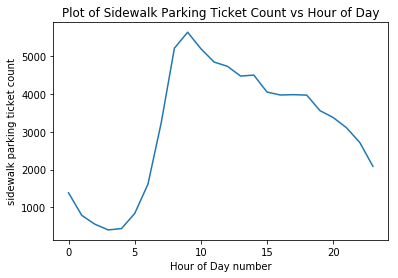

In [10]:
plt.plot(nypd_hour_df[['sidewalk_parking_count']])
plt.xlabel('Hour of Day number')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Hour of Day')

We can see a spike in the count of sidewalk parking tickets in the morning at 9am, and a gradual decline as the day wears on.

### Count by Day of Week

In [11]:
nypd_day_df = nypd_df.groupby(['day_of_week'], as_index=False)['Agency'].count()
nypd_day_df.columns = ['day_of_week', 'sidewalk_parking_count']

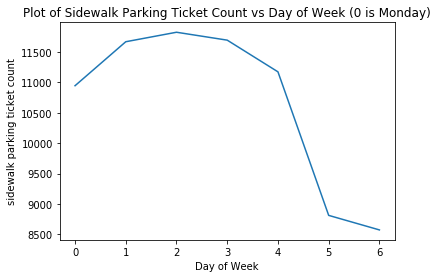

In [12]:
plt.plot(nypd_day_df[['sidewalk_parking_count']])
plt.xlabel('Day of Week')
plt.ylabel('sidewalk parking ticket count')
plt.title('Plot of Sidewalk Parking Ticket Count vs Day of Week (0 is Monday)')

Looks like ticket count drops off dramatically on Saturdays and Sundays, indicating the ticketers really are only working on weekdays.

### Count by Day of Week / Hour of Day

In [13]:
nypd_day_hour_df = nypd_df.groupby(['day_of_week', 'hour_of_day'], as_index=False)['Agency'].count()
nypd_day_hour_df.columns = ['day_of_week', 'hour_of_day', 'sidewalk_parking_count']

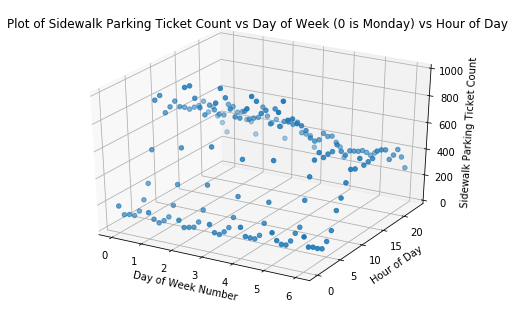

In [14]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(nypd_day_hour_df.day_of_week, nypd_day_hour_df.hour_of_day, nypd_day_hour_df.sidewalk_parking_count)
ax.set_xlabel('Day of Week Number')
ax.set_ylabel('Hour of Day')
ax.set_zlabel('Sidewalk Parking Ticket Count')
ax.set_title('Plot of Sidewalk Parking Ticket Count vs Day of Week (0 is Monday) vs Hour of Day')
plt.show()

### Read in ACS Data

In [15]:
'''
taken from: 
https://public.enigma.com/datasets/household-size-by-vehicles-available/f9d2a838-00ce-4d17-90bb-9a20e22f515a?filter=%2B%5B%3Estusab%5BNY%5D%5D
'''
acs_df_raw = pd.read_csv(data_folder+'/ACS_vehicle_data.csv')
#subset to just NYC
acs_df = acs_df_raw[(acs_df_raw.b08201_001 == "795") & (acs_df_raw.sumlevel == "NY")]
acs_nyc_df = acs_df[acs_df['name'].str.contains("NYC")]
acs_nyc_df = acs_nyc_df.iloc[:,0:17]
acs_nyc_df.columns = ['name', 'name2', 'geoid', 'state', 'summary_level', 'total_pop',\
                     'total_pop_moe', 'no_vehicle_pop', 'no_vehicle_pop_moe',\
                     'one_vehicle_pop', 'one_vehicle_pop_moe', 'two_vehicle_pop',\
                     'two_vehicle_pop_moe', 'three_vehicle_pop', 'three_vehicle_pop_moe',\
                     'four_or_more_vehicle_pop', 'four_or_more_vehicle_pop_moe']
#acs_nyc_df = acs_nyc_df[acs_nyc_df.total_pop!="None"]

### Do a little regex stuff to get useable x-walk for community district name

In [16]:
# Harmonize community district name for ACS

dict_boro2 = {'Bronx': 'BX', 'Brooklyn': 'BK', 'Manhattan': 'MN', 'Staten': 'SI', 'Queens': 'QN'}

def add_zero(f):
    if len(f) == 1:
        return '0'+f
    else:
        return f

acs_nyc_df['cd_num'] = [re.search("[0-9]+", i).group(0) for i in acs_nyc_df['name']]
acs_nyc_df['cd_num_2'] = [add_zero(i) for i in acs_nyc_df['cd_num']]

acs_nyc_df['boro'] = [dict_boro2[re.search('[^\s]+', i[4:]).group(0)] for i in acs_nyc_df['name']]

acs_nyc_df['cd_id'] = acs_nyc_df['boro'] + acs_nyc_df['cd_num_2']

In [17]:
acs_nyc_df = acs_nyc_df.replace(to_replace="None", value=0)

In [18]:
acs_nyc_df = acs_nyc_df.replace(to_replace="None", value=0)
acs_nyc_df = acs_nyc_df[['cd_id', 'boro', 'total_pop', 'no_vehicle_pop', 'one_vehicle_pop', 'two_vehicle_pop', \
                         'three_vehicle_pop', 'four_or_more_vehicle_pop']]
acs_nyc_df['vehicle_pop'] = acs_nyc_df['one_vehicle_pop'].astype(int) + 2*acs_nyc_df['two_vehicle_pop'].astype(int) + \
                            3*acs_nyc_df['three_vehicle_pop'].astype(int) + 4*acs_nyc_df['four_or_more_vehicle_pop'].astype(int)

acs_nyc_df['total_pop'] = acs_nyc_df['total_pop'].astype(int)
acs_nyc_df = acs_nyc_df[['cd_id', 'boro', 'total_pop', 'vehicle_pop']]
acs_nyc_df.head()

cd_id boro  total_pop  vehicle_pop
3252  MN06   MN          0            0
4426  BX08   BX      41340        31602
4427  BX12   BX      47321        38848
4428  BX10   BX      47025        43162
4429  BX11   BX      43622        34441

### Merge ACS data to NYPD data

In [19]:
nypd_df['cd_num'] = nypd_df['Community Board'].str.split(' ', 1).str[0]
nypd_df['cd_boro'] = nypd_df['Community Board'].str.split(' ', 1).str[1]

In [20]:
# Harmonize identifier

dict_boro = {'BRONX': 'BX', 'BROOKLYN': 'BK', 'MANHATTAN': 'MN', 'STATEN ISLAND': 'SI', 'QUEENS': 'QN'}

nypd_df['cd_num'] = nypd_df['Community Board'].str.split(' ', 1).str[0]
nypd_df['cd_boro'] = nypd_df['Community Board'].str.split(' ', 1).str[1]

nypd_df['cd_id'] = nypd_df['cd_boro'].map(dict_boro) + nypd_df['cd_num']
nypd_df['day_hour'] = pd.to_datetime(nypd_df['create_date'].astype(str) + ' ' + nypd_df['hour_of_day'].astype(str)+':00')
nypd_time_df = nypd_df.groupby(['cd_id', 'day_hour'], as_index=False)['Agency'].count()
nypd_time_df.columns = ['cd_id', 'day_hour', 'sidewalk_parking_count']

In [21]:
### drop bad community districts
nypd_time_df = nypd_time_df.dropna()
nypd_time_df = nypd_time_df[nypd_time_df.cd_id.str[2:]!="Unspecified"]
nypd_time_df = nypd_time_df[nypd_time_df['cd_id'].str[2:].astype(int)<=18]

In [22]:
nypd_time_df.head()

cd_id            day_hour  sidewalk_parking_count
0  BK01 2010-06-09 13:00:00                       1
1  BK01 2010-06-09 18:00:00                       1
2  BK01 2010-06-10 23:00:00                       1
3  BK01 2010-06-11 16:00:00                       1
4  BK01 2010-06-15 14:00:00                       1

In [23]:
#generate hourly date range for same number of weeks as mta data.
hours = pd.date_range('6/9/2010', periods=(24*365*7)+(24*10), freq='H')
blank_df = pd.DataFrame(columns=['cd_id','day_hour', 'sidewalk_parking_count'])
for i in nypd_time_df['cd_id'].unique():
    temp_df = pd.DataFrame(columns=['cd_id','day_hour', 'sidewalk_parking_count'])
    temp_df['day_hour'] = hours
    temp_df['sidewalk_parking_count'] = 0
    temp_df['cd_id'] = str(i)
    blank_df = pd.concat([blank_df, temp_df])

nypd_time_df = blank_df.merge(nypd_time_df, on=['cd_id', 'day_hour'], how='left')
nypd_time_df = nypd_time_df.fillna(0)
nypd_time_df = nypd_time_df[['cd_id', 'day_hour', 'sidewalk_parking_count_y']]
nypd_time_df.columns = ['cd_id', 'day_hour', 'sidewalk_parking_count']
nypd_time_df.head()

cd_id            day_hour  sidewalk_parking_count
0  BK01 2010-06-09 00:00:00                     0.0
1  BK01 2010-06-09 01:00:00                     0.0
2  BK01 2010-06-09 02:00:00                     0.0
3  BK01 2010-06-09 03:00:00                     0.0
4  BK01 2010-06-09 04:00:00                     0.0

In [24]:
nypd_cd_acs_df = nypd_time_df.merge(acs_nyc_df, on='cd_id', how='left')
nypd_cd_acs_df['boro'] = nypd_cd_acs_df['cd_id'].str[:2]
nypd_cd_acs_df = nypd_cd_acs_df.fillna(0)

In [25]:
#replace missing cd stats with boro averages
replace_df = acs_nyc_df[acs_nyc_df.total_pop > 0]
replace_df = replace_df.groupby(['boro'], as_index=False)['total_pop', 'vehicle_pop'].mean()

In [26]:
nypd_cd_acs_df = nypd_cd_acs_df.merge(replace_df, on='boro', how='left')

In [27]:
nypd_cd_acs_df['total_pop_x'] = np.where(nypd_cd_acs_df['total_pop_x'] == 0, nypd_cd_acs_df['total_pop_y'],\
                                          nypd_cd_acs_df['total_pop_x'])
nypd_cd_acs_df['vehicle_pop_x'] = np.where(nypd_cd_acs_df['vehicle_pop_x']==0, nypd_cd_acs_df['vehicle_pop_y'],\
                                            nypd_cd_acs_df['vehicle_pop_x'])
nypd_cd_acs_df = nypd_cd_acs_df[['cd_id', 'day_hour', 'total_pop_x', 'vehicle_pop_x', 'sidewalk_parking_count']]
nypd_cd_acs_df.columns = ['cd_id', 'day_hour', 'total_pop', 'vehicle_pop', 'sidewalk_parking_count']

In [28]:
nypd_cd_acs_df['pct_sidewalk_parking'] = nypd_cd_acs_df.sidewalk_parking_count * 1.0 / nypd_cd_acs_df.vehicle_pop

# Fourier Transformation Analysis of Street Parking Enforcement

In [103]:
df['pct_sidewalk_parking'].iloc[0:-14].mean()

2.4929179721831383e-07

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


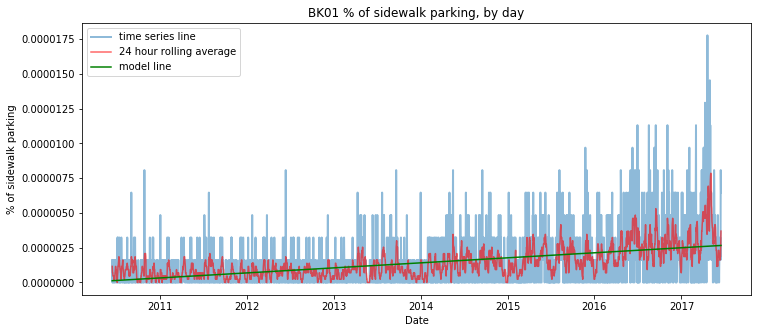

Community District:  BK01
Ratio =  0.25641025641
fitted model coefficient =  9.90636294633e-10
fitted model coefficient 95% confidence interval:  9.48342022477e-10 1.03293056679e-09
R-squared of fitted model =  0.452048012385




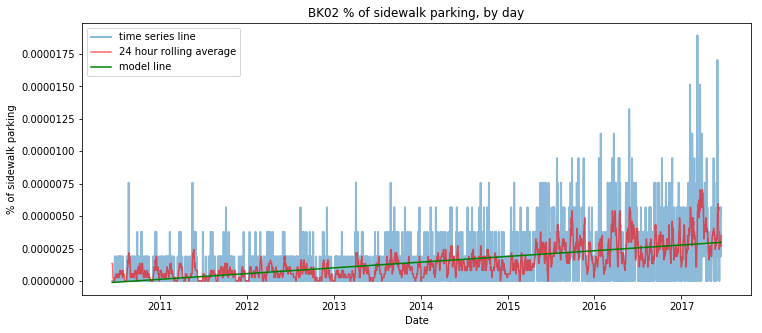

Community District:  BK02
Ratio =  0.047619047619
fitted model coefficient =  1.20712314912e-09
fitted model coefficient 95% confidence interval:  1.16221707863e-09 1.25202921962e-09
R-squared of fitted model =  0.520751488338




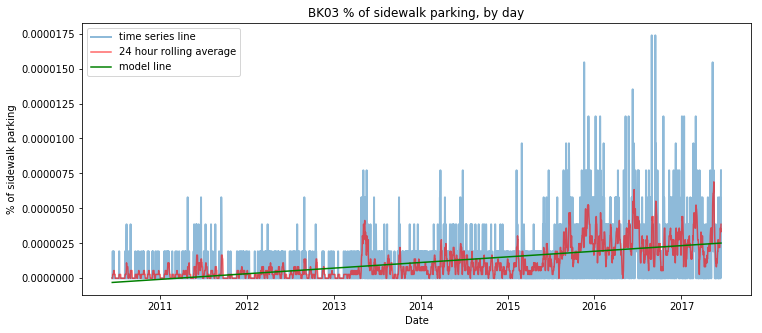

Community District:  BK03
Ratio =  0.0761904761905
fitted model coefficient =  1.10109777083e-09
fitted model coefficient 95% confidence interval:  1.05737822442e-09 1.14481731724e-09
R-squared of fitted model =  0.488188307001




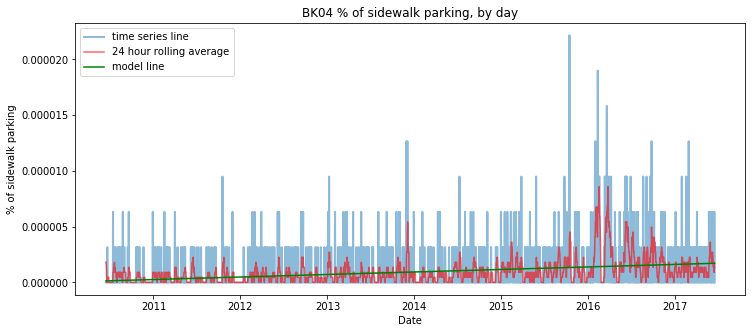

Community District:  BK04
Ratio =  0.0732600732601
fitted model coefficient =  6.17957256151e-10
fitted model coefficient 95% confidence interval:  5.67219882854e-10 6.68694629449e-10
R-squared of fitted model =  0.182384087768




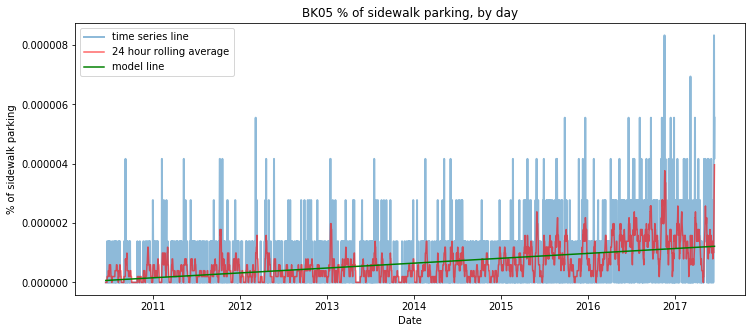

Community District:  BK05
Ratio =  0.170068027211
fitted model coefficient =  4.49909929715e-10
fitted model coefficient 95% confidence interval:  4.25908725576e-10 4.73911133854e-10
R-squared of fitted model =  0.345720486142




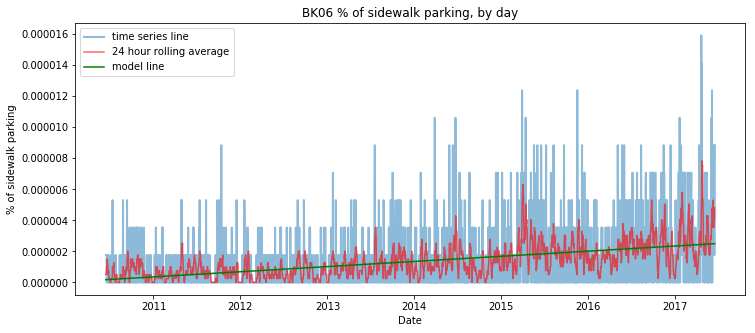

Community District:  BK06
Ratio =  0.144927536232
fitted model coefficient =  9.07593322173e-10
fitted model coefficient 95% confidence interval:  8.64472402439e-10 9.50714241908e-10
R-squared of fitted model =  0.399820140731




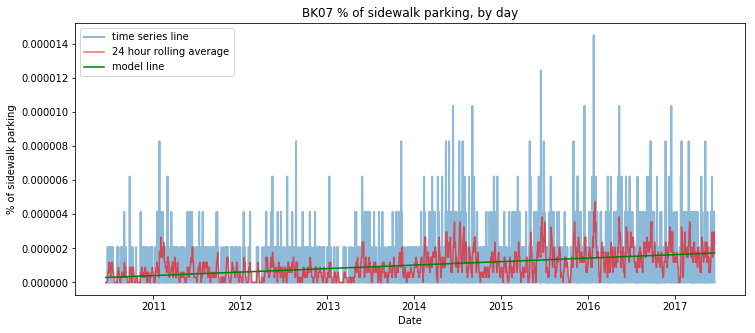

Community District:  BK07
Ratio =  0.238095238095
fitted model coefficient =  5.61197751192e-10
fitted model coefficient 95% confidence interval:  5.26901288277e-10 5.95494214108e-10
R-squared of fitted model =  0.287055371589




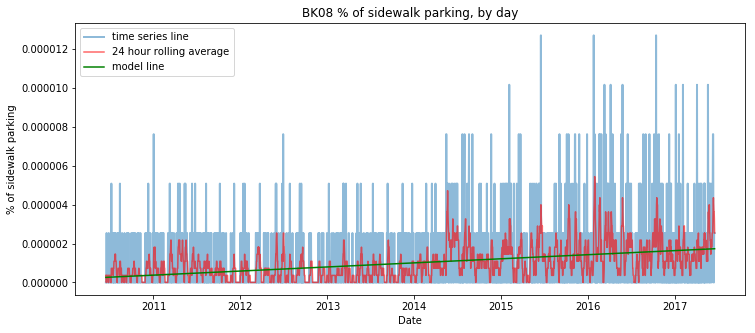

Community District:  BK08
Ratio =  0.0907029478458
fitted model coefficient =  5.74954895196e-10
fitted model coefficient 95% confidence interval:  5.35995805264e-10 6.13913985129e-10
R-squared of fitted model =  0.246710895017




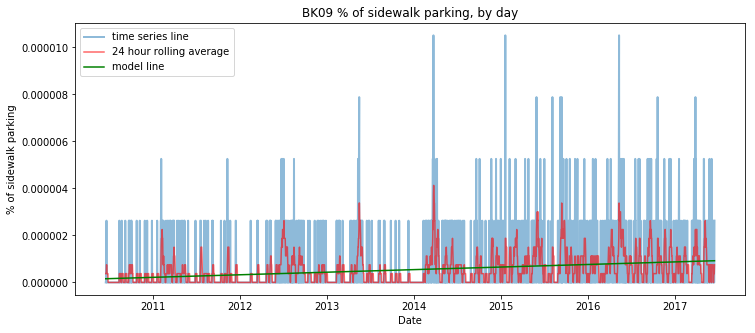

Community District:  BK09
Ratio =  0.31746031746
fitted model coefficient =  2.99444520887e-10
fitted model coefficient 95% confidence interval:  2.69236541634e-10 3.2965250014e-10
R-squared of fitted model =  0.128740093446




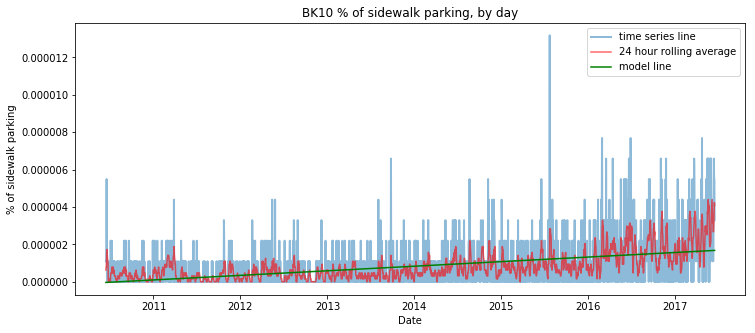

Community District:  BK10
Ratio =  0.17316017316
fitted model coefficient =  6.69646714753e-10
fitted model coefficient 95% confidence interval:  6.3993674448e-10 6.99356685027e-10
R-squared of fitted model =  0.433089836002




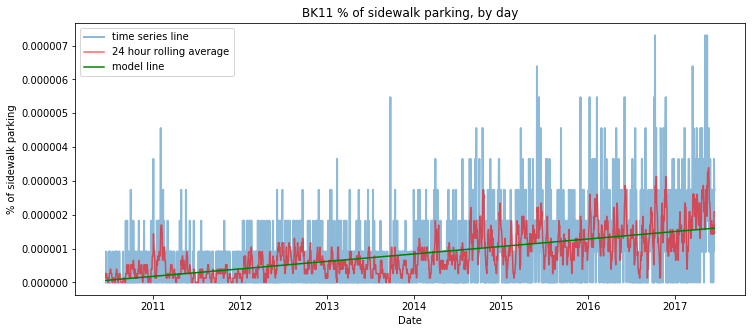

Community District:  BK11
Ratio =  0.1221001221
fitted model coefficient =  6.03769160676e-10
fitted model coefficient 95% confidence interval:  5.80402456126e-10 6.27135865226e-10
R-squared of fitted model =  0.500992191592




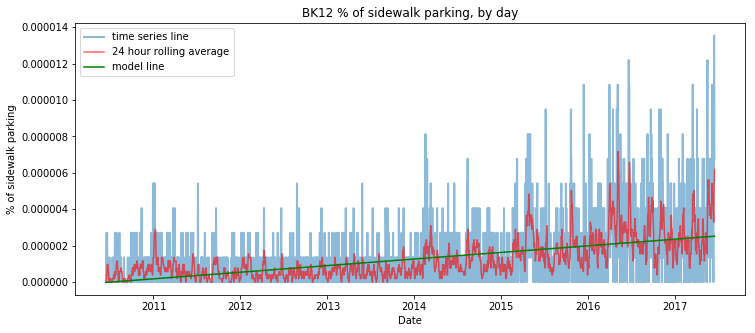

Community District:  BK12
Ratio =  0.0804828973843
fitted model coefficient =  9.93434024114e-10
fitted model coefficient 95% confidence interval:  9.51046708451e-10 1.03582133978e-09
R-squared of fitted model =  0.4523565181




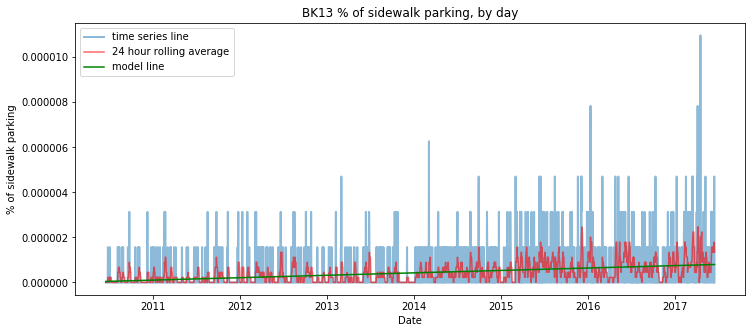

Community District:  BK13
Ratio =  0.112044817927
fitted model coefficient =  2.93566226301e-10
fitted model coefficient 95% confidence interval:  2.74126657047e-10 3.13005795556e-10
R-squared of fitted model =  0.255363982082




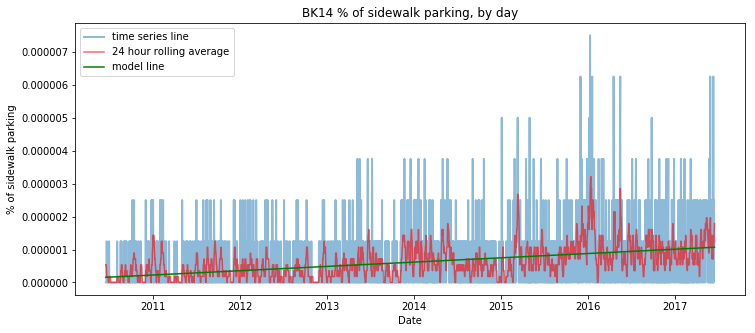

Community District:  BK14
Ratio =  0.0952380952381
fitted model coefficient =  3.57139226086e-10
fitted model coefficient 95% confidence interval:  3.36027448205e-10 3.78251003966e-10
R-squared of fitted model =  0.300860913946




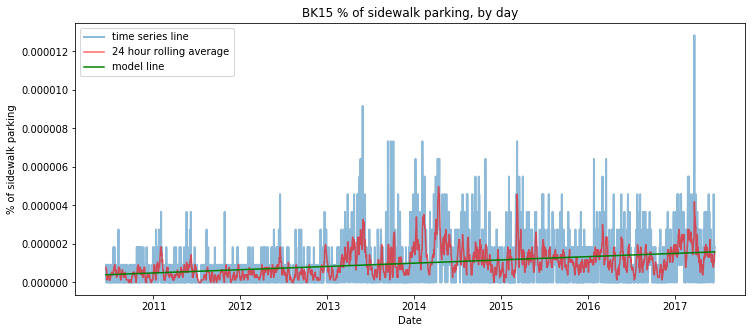

Community District:  BK15
Ratio =  0.21978021978
fitted model coefficient =  4.63983055447e-10
fitted model coefficient 95% confidence interval:  4.31317012197e-10 4.96649098697e-10
R-squared of fitted model =  0.232764425086




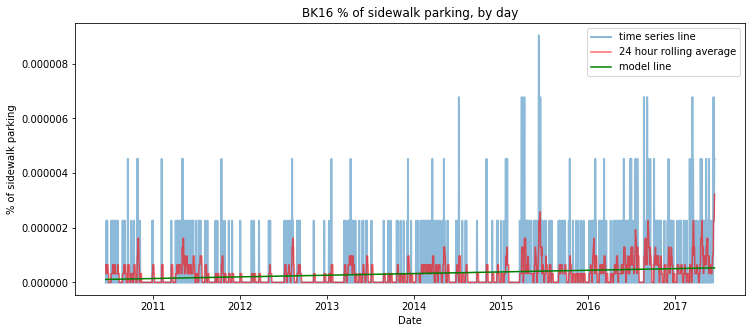

Community District:  BK16
Ratio =  0.15873015873
fitted model coefficient =  1.65285379271e-10
fitted model coefficient 95% confidence interval:  1.44895847595e-10 1.85674910948e-10
R-squared of fitted model =  0.0899302409346




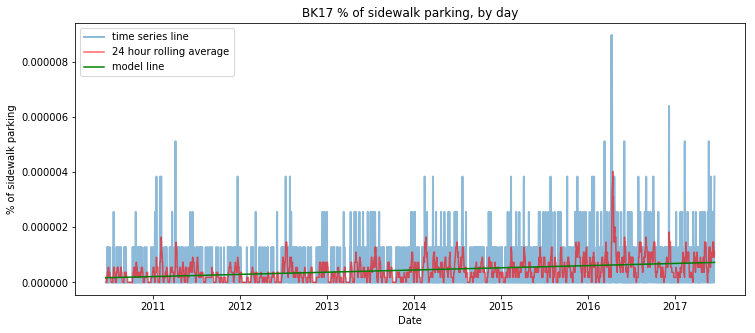

Community District:  BK17
Ratio =  0.253968253968
fitted model coefficient =  2.17101227043e-10
fitted model coefficient 95% confidence interval:  1.98397154105e-10 2.35805299981e-10
R-squared of fitted model =  0.168464911749




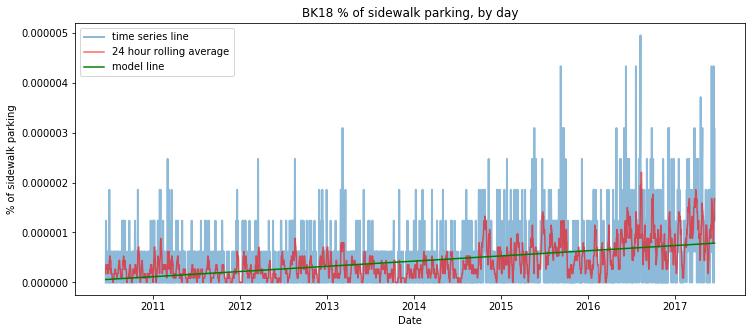

Community District:  BK18
Ratio =  0.25974025974
fitted model coefficient =  2.84282361608e-10
fitted model coefficient 95% confidence interval:  2.69637189125e-10 2.98927534091e-10
R-squared of fitted model =  0.361680798953




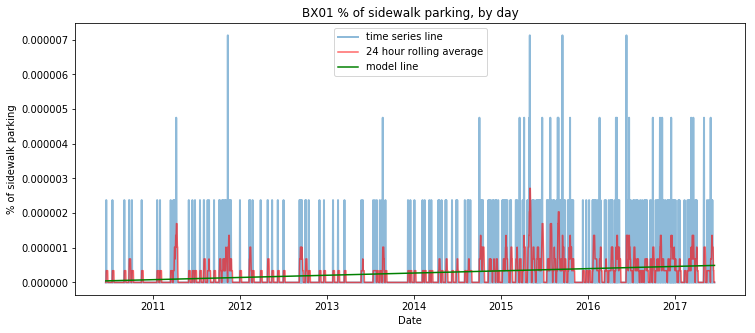

Community District:  BX01
Ratio =  0.190476190476
fitted model coefficient =  1.74338944609e-10
fitted model coefficient 95% confidence interval:  1.55995420654e-10 1.92682468563e-10
R-squared of fitted model =  0.11958759537




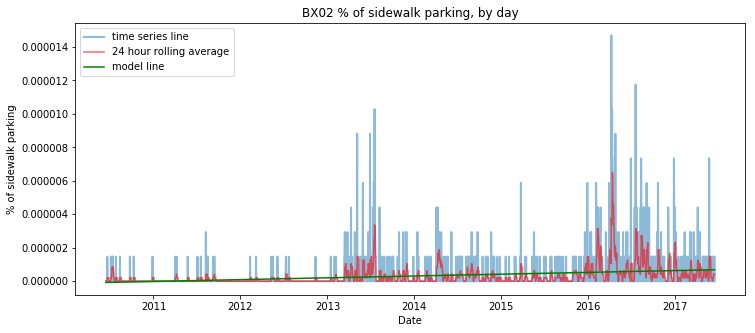

Community District:  BX02
Ratio =  0.238095238095
fitted model coefficient =  2.96651477464e-10
fitted model coefficient 95% confidence interval:  2.69956074327e-10 3.23346880602e-10
R-squared of fitted model =  0.156611739436




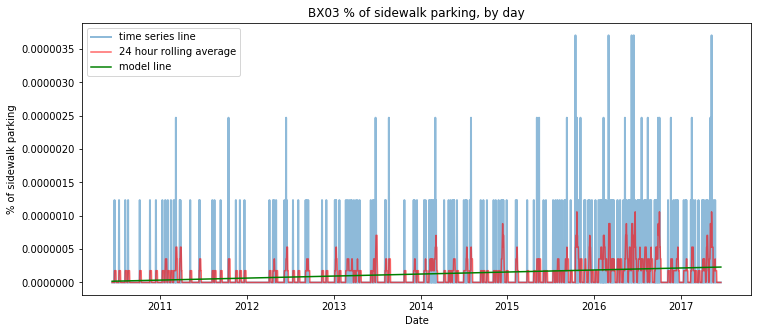

Community District:  BX03
Ratio =  0
fitted model coefficient =  8.31357672748e-11
fitted model coefficient 95% confidence interval:  7.43899690555e-11 9.18815654941e-11
R-squared of fitted model =  0.119624844909




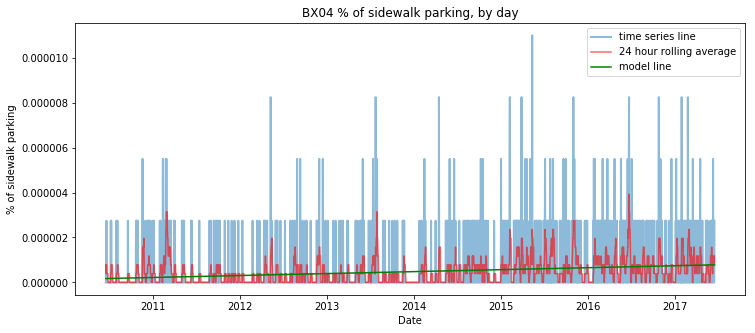

Community District:  BX04
Ratio =  0.15873015873
fitted model coefficient =  2.38081194661e-10
fitted model coefficient 95% confidence interval:  2.11376391649e-10 2.64785997673e-10
R-squared of fitted model =  0.106761696063




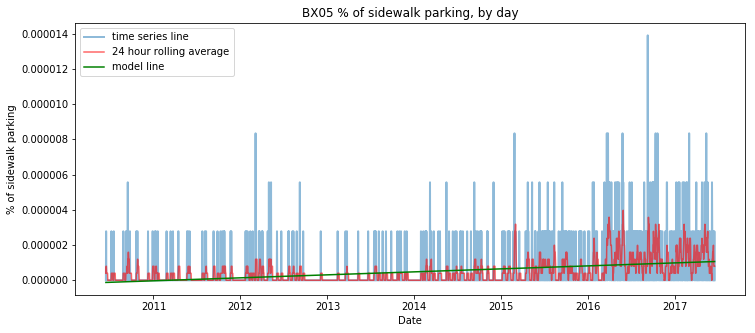

Community District:  BX05
Ratio =  0.136054421769
fitted model coefficient =  4.63755880278e-10
fitted model coefficient 95% confidence interval:  4.34977500658e-10 4.92534259899e-10
R-squared of fitted model =  0.280835089758




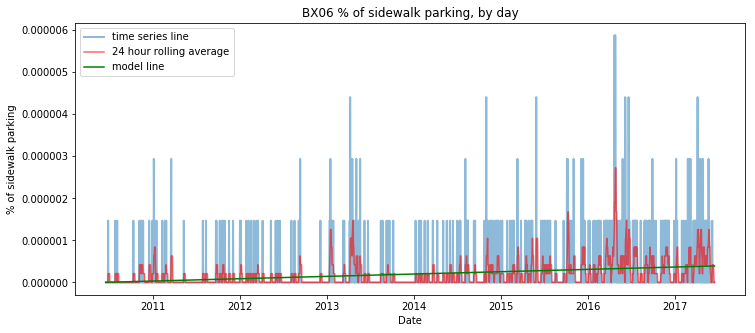

Community District:  BX06
Ratio =  0.47619047619
fitted model coefficient =  1.51936795514e-10
fitted model coefficient 95% confidence interval:  1.3769238265e-10 1.66181208378e-10
R-squared of fitted model =  0.146091472765




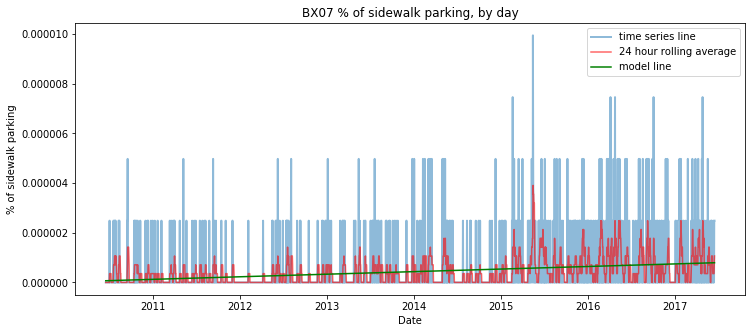

Community District:  BX07
Ratio =  0.190476190476
fitted model coefficient =  2.8321663846e-10
fitted model coefficient 95% confidence interval:  2.58530185228e-10 3.07903091692e-10
R-squared of fitted model =  0.165221983752




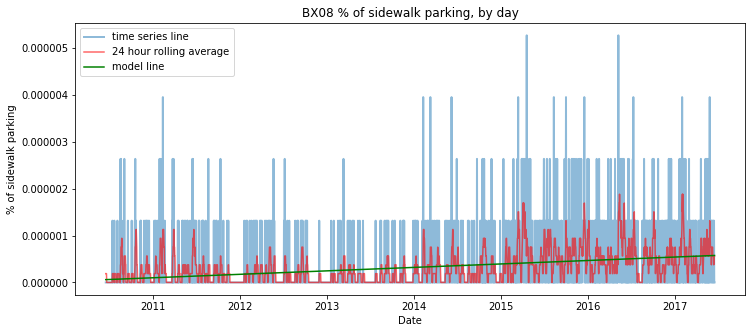

Community District:  BX08
Ratio =  0.0
fitted model coefficient =  2.01677663506e-10
fitted model coefficient 95% confidence interval:  1.85928083648e-10 2.17427243364e-10
R-squared of fitted model =  0.197803918473




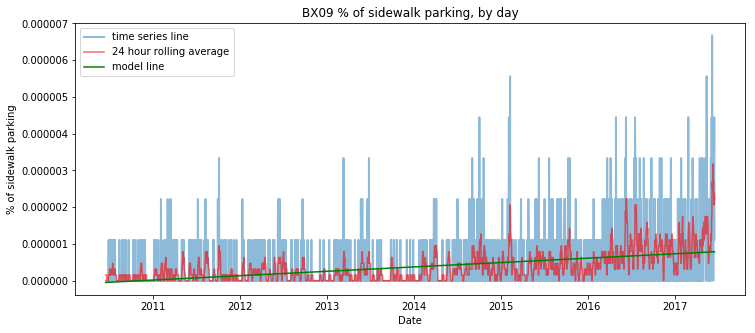

Community District:  BX09
Ratio =  0.0501253132832
fitted model coefficient =  3.25829287487e-10
fitted model coefficient 95% confidence interval:  3.09020354794e-10 3.4263822018e-10
R-squared of fitted model =  0.361037349179




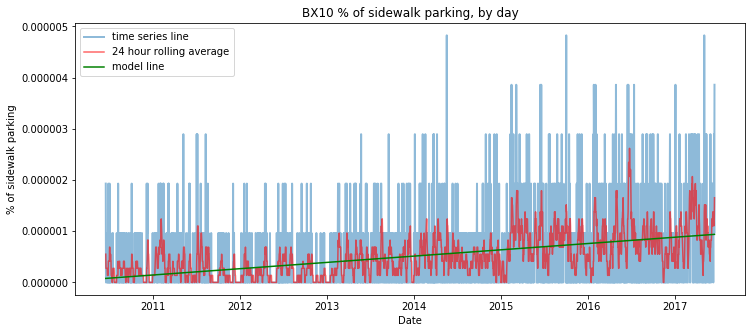

Community District:  BX10
Ratio =  0.357142857143
fitted model coefficient =  3.36312727203e-10
fitted model coefficient 95% confidence interval:  3.19185699273e-10 3.53439755132e-10
R-squared of fitted model =  0.367019758431




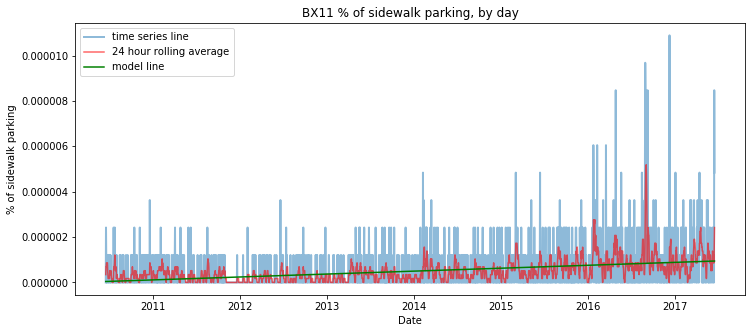

Community District:  BX11
Ratio =  0.408163265306
fitted model coefficient =  3.5235778433e-10
fitted model coefficient 95% confidence interval:  3.3067039168e-10 3.7404517698e-10
R-squared of fitted model =  0.284151930831




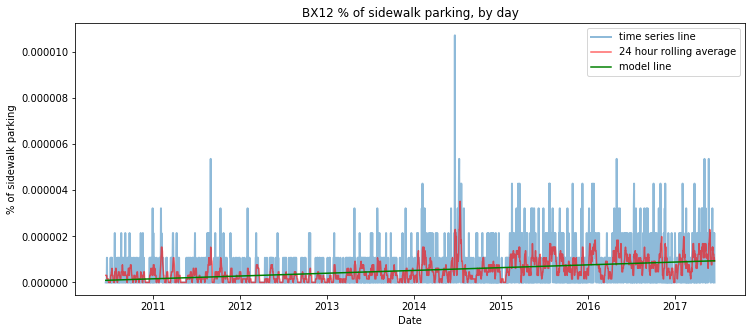

Community District:  BX12
Ratio =  0.0865800865801
fitted model coefficient =  3.31404504703e-10
fitted model coefficient 95% confidence interval:  3.11404424668e-10 3.51404584737e-10
R-squared of fitted model =  0.292228760577




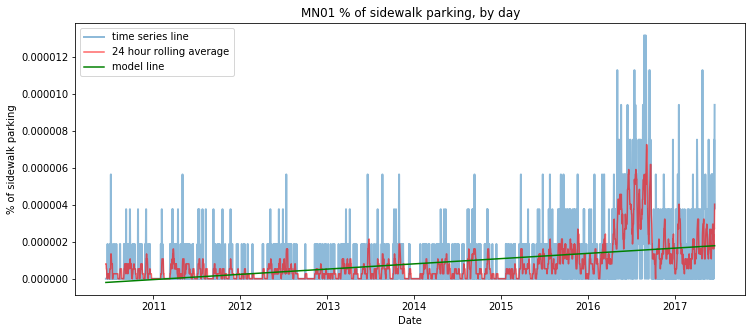

Community District:  MN01
Ratio =  0.119047619048
fitted model coefficient =  7.7746830274e-10
fitted model coefficient 95% confidence interval:  7.31426675951e-10 8.23509929529e-10
R-squared of fitted model =  0.300105203569




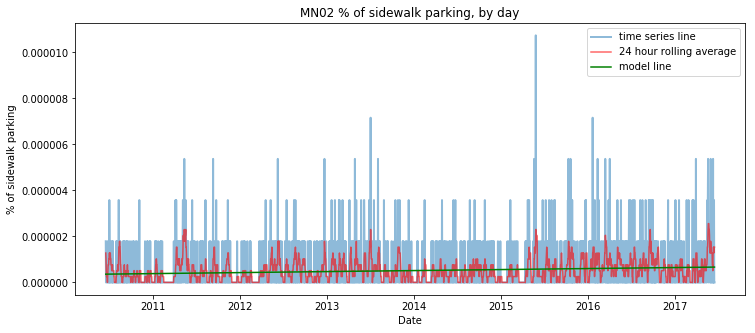

Community District:  MN02
Ratio =  0.612244897959
fitted model coefficient =  1.20102074874e-10
fitted model coefficient 95% confidence interval:  9.69953660023e-11 1.43208783747e-10
R-squared of fitted model =  0.0390397438355




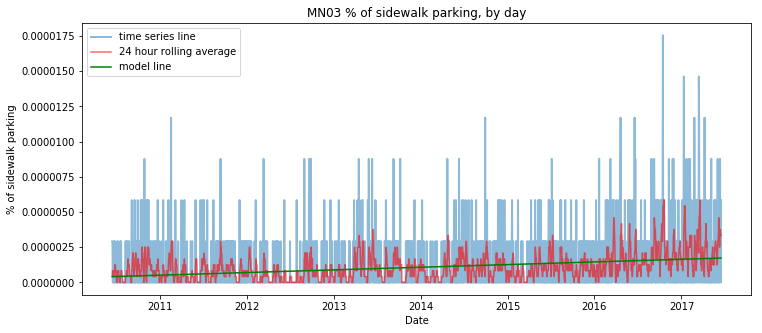

Community District:  MN03
Ratio =  0.238095238095
fitted model coefficient =  5.15564547884e-10
fitted model coefficient 95% confidence interval:  4.71547654068e-10 5.595814417e-10
R-squared of fitted model =  0.171020377494




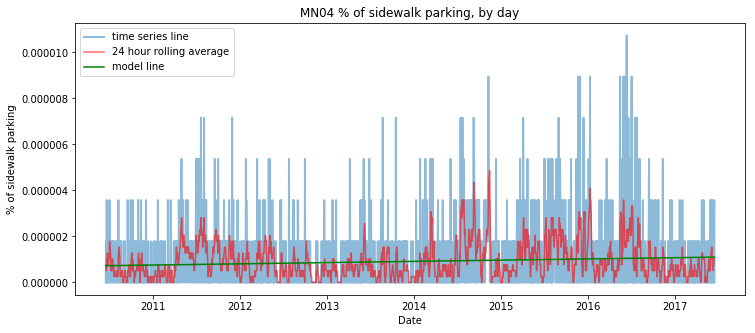

Community District:  MN04
Ratio =  0.952380952381
fitted model coefficient =  1.45925858062e-10
fitted model coefficient 95% confidence interval:  1.07042644445e-10 1.84809071679e-10
R-squared of fitted model =  0.0207402885209




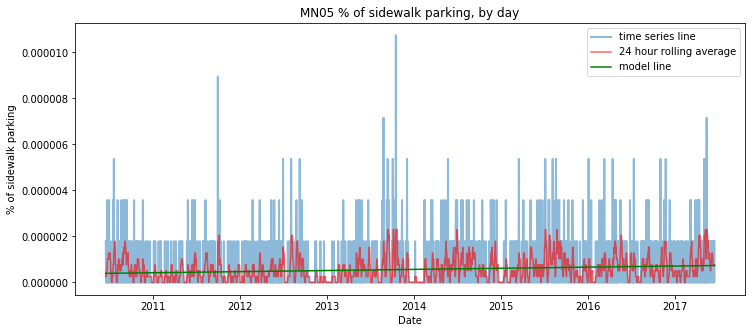

Community District:  MN05
Ratio =  1.16402116402
fitted model coefficient =  1.32846184464e-10
fitted model coefficient 95% confidence interval:  1.07475001519e-10 1.58217367409e-10
R-squared of fitted model =  0.039595656674




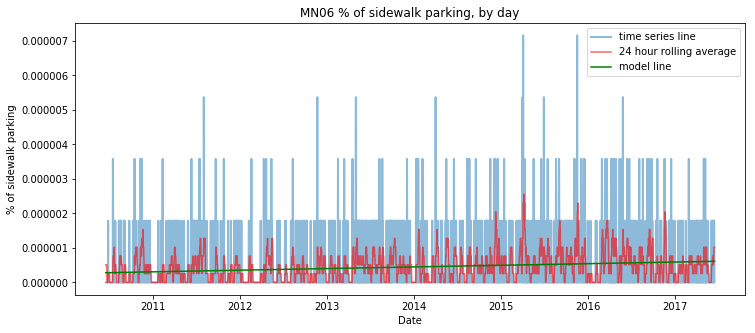

Community District:  MN06
Ratio =  0.136054421769
fitted model coefficient =  1.29104819686e-10
fitted model coefficient 95% confidence interval:  1.09047488557e-10 1.49162150815e-10
R-squared of fitted model =  0.0586498004413




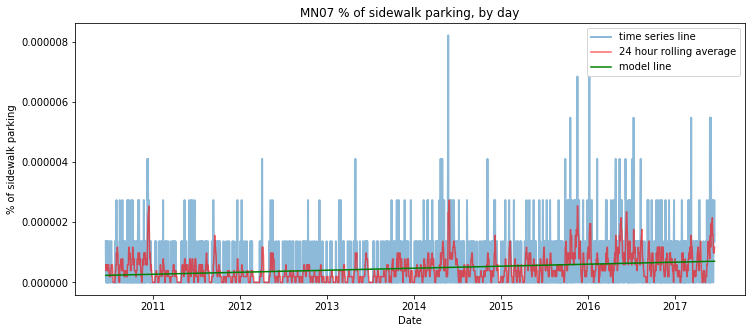

Community District:  MN07
Ratio =  0.248447204969
fitted model coefficient =  1.83239828537e-10
fitted model coefficient 95% confidence interval:  1.62552944358e-10 2.03926712717e-10
R-squared of fitted model =  0.10553350505




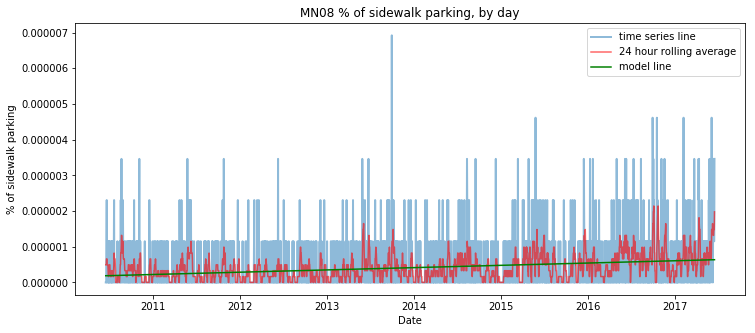

Community District:  MN08
Ratio =  0.25974025974
fitted model coefficient =  1.75450709454e-10
fitted model coefficient 95% confidence interval:  1.59087244106e-10 1.91814174801e-10
R-squared of fitted model =  0.147395438811




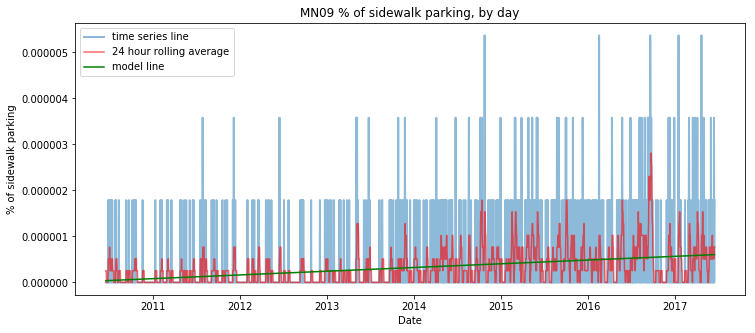

Community District:  MN09
Ratio =  0.408163265306
fitted model coefficient =  2.21113065708e-10
fitted model coefficient 95% confidence interval:  2.03345438167e-10 2.38880693249e-10
R-squared of fitted model =  0.188896143977




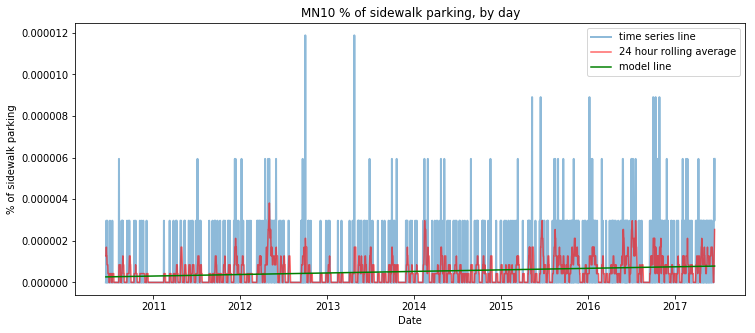

Community District:  MN10
Ratio =  0.285714285714
fitted model coefficient =  2.02949916069e-10
fitted model coefficient 95% confidence interval:  1.73816227454e-10 2.32083604684e-10
R-squared of fitted model =  0.0680102888495




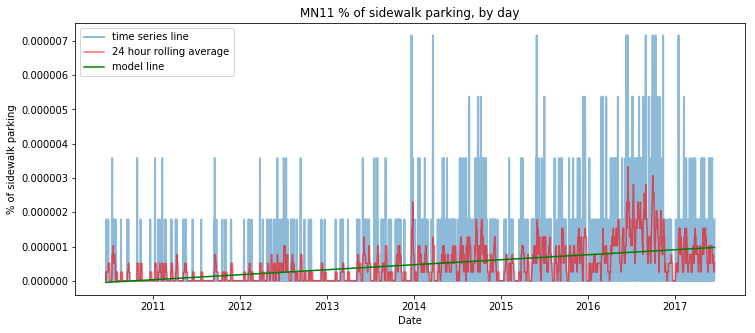

Community District:  MN11
Ratio =  0.408163265306
fitted model coefficient =  3.98993660934e-10
fitted model coefficient 95% confidence interval:  3.7663853901e-10 4.21348782858e-10
R-squared of fitted model =  0.323877103614




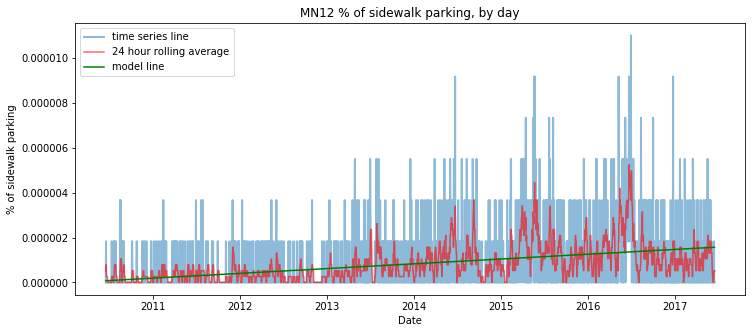

Community District:  MN12
Ratio =  0.10582010582
fitted model coefficient =  5.83536749108e-10
fitted model coefficient 95% confidence interval:  5.49024140352e-10 6.18049357863e-10
R-squared of fitted model =  0.300645601807




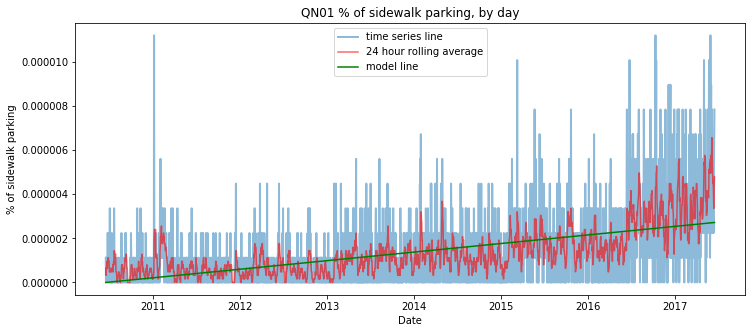

Community District:  QN01
Ratio =  0.153256704981
fitted model coefficient =  1.06269421041e-09
fitted model coefficient 95% confidence interval:  1.0236480582e-09 1.10174036261e-09
R-squared of fitted model =  0.52693535155




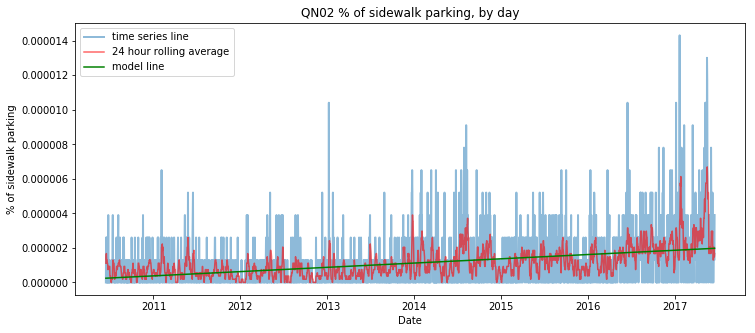

Community District:  QN02
Ratio =  0.380952380952
fitted model coefficient =  6.76951334652e-10
fitted model coefficient 95% confidence interval:  6.40531420087e-10 7.13371249216e-10
R-squared of fitted model =  0.341903388263




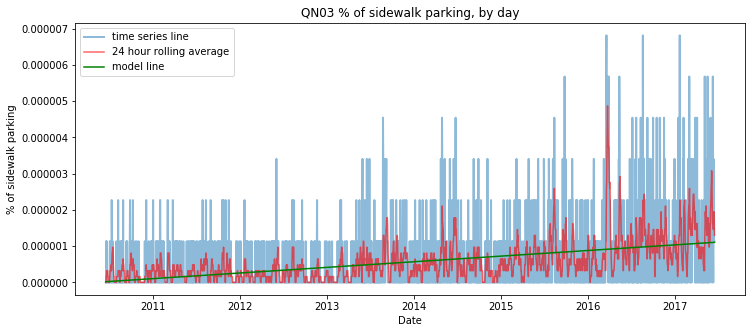

Community District:  QN03
Ratio =  0.108843537415
fitted model coefficient =  4.24312596616e-10
fitted model coefficient 95% confidence interval:  4.01017221415e-10 4.47607971817e-10
R-squared of fitted model =  0.33284184821




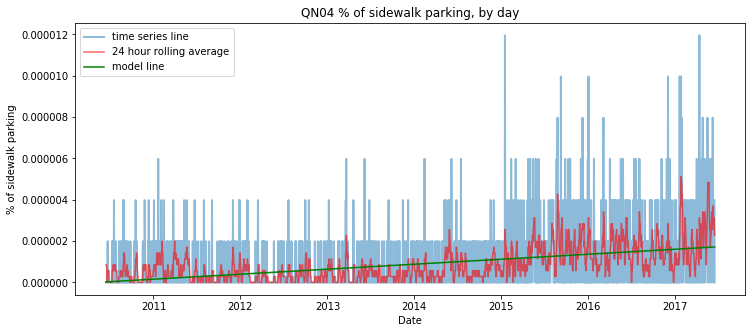

Community District:  QN04
Ratio =  0.0634920634921
fitted model coefficient =  6.60311740901e-10
fitted model coefficient 95% confidence interval:  6.26111155809e-10 6.94512325992e-10
R-squared of fitted model =  0.35919673513




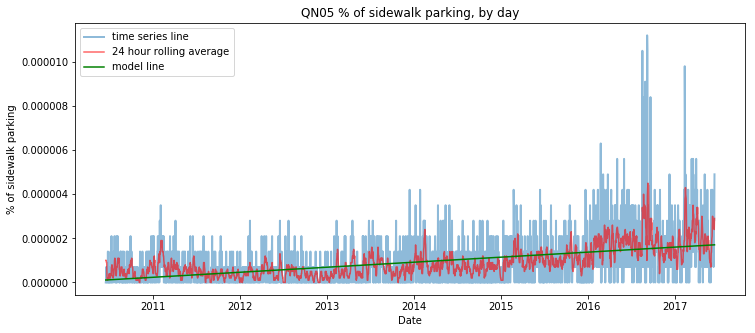

Community District:  QN05
Ratio =  0.109289617486
fitted model coefficient =  6.23924734741e-10
fitted model coefficient 95% confidence interval:  5.97723775532e-10 6.5012569395e-10
R-squared of fitted model =  0.460253189247




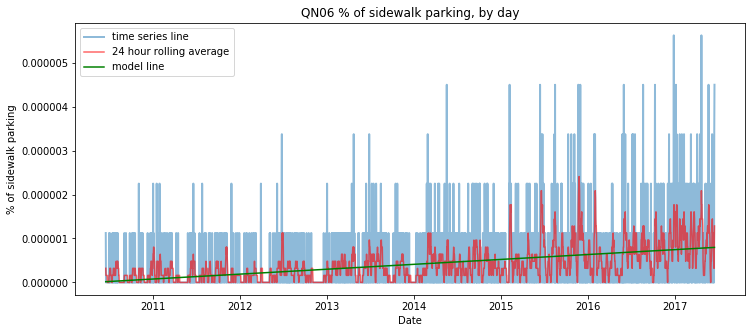

Community District:  QN06
Ratio =  0.204081632653
fitted model coefficient =  3.04898460458e-10
fitted model coefficient 95% confidence interval:  2.88325290468e-10 3.21471630449e-10
R-squared of fitted model =  0.337287966596




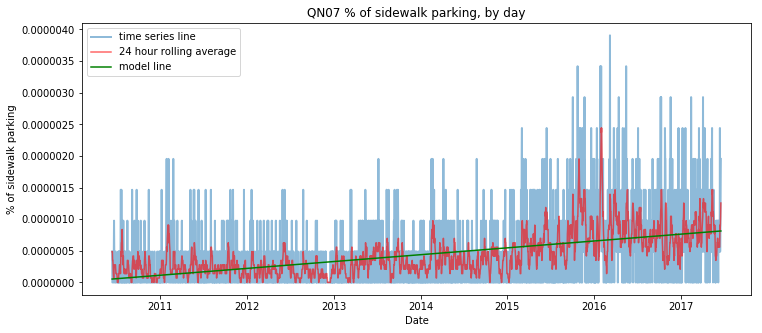

Community District:  QN07
Ratio =  0.208333333333
fitted model coefficient =  2.96956994148e-10
fitted model coefficient 95% confidence interval:  2.84121674821e-10 3.09792313476e-10
R-squared of fitted model =  0.445957538135




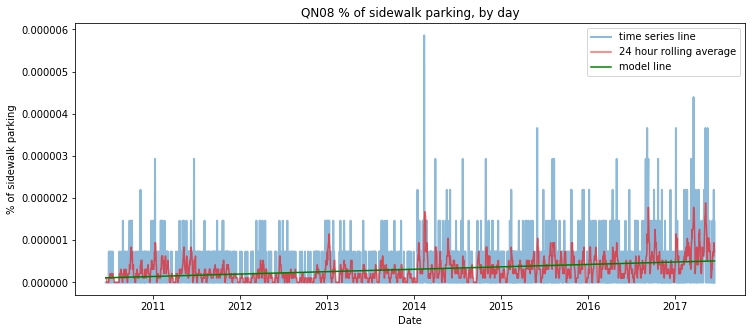

Community District:  QN08
Ratio =  0.136054421769
fitted model coefficient =  1.56254547512e-10
fitted model coefficient 95% confidence interval:  1.43295153775e-10 1.6921394125e-10
R-squared of fitted model =  0.179393807895




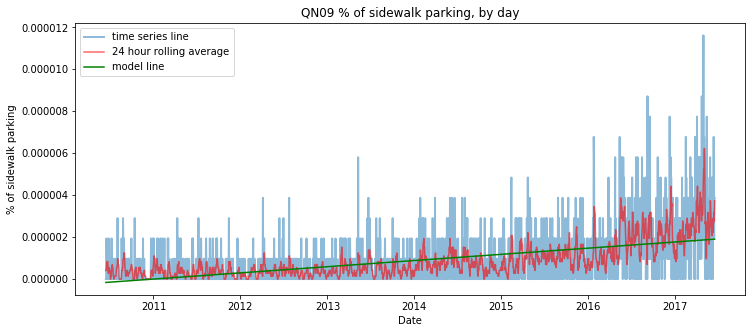

Community District:  QN09
Ratio =  0.145278450363
fitted model coefficient =  8.0654104518e-10
fitted model coefficient 95% confidence interval:  7.75964521179e-10 8.3711756918e-10
R-squared of fitted model =  0.511311487724




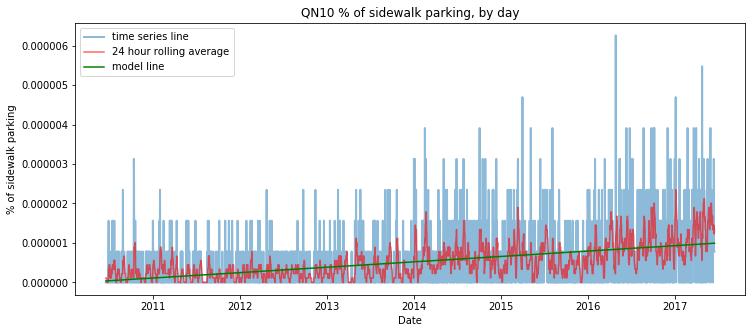

Community District:  QN10
Ratio =  0.116144018583
fitted model coefficient =  3.73504355433e-10
fitted model coefficient 95% confidence interval:  3.56867764543e-10 3.90140946323e-10
R-squared of fitted model =  0.431154933786




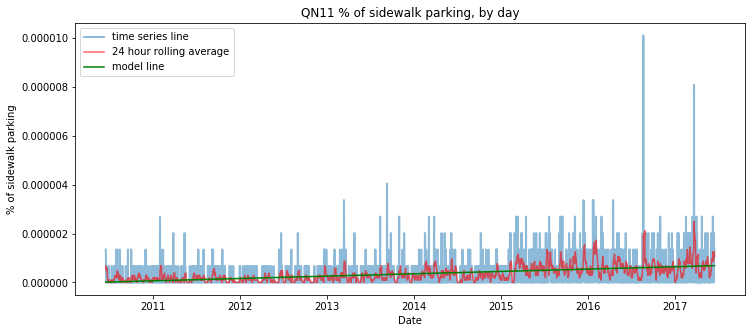

Community District:  QN11
Ratio =  0.176366843034
fitted model coefficient =  2.63052897619e-10
fitted model coefficient 95% confidence interval:  2.49902059662e-10 2.76203735577e-10
R-squared of fitted model =  0.375650403723




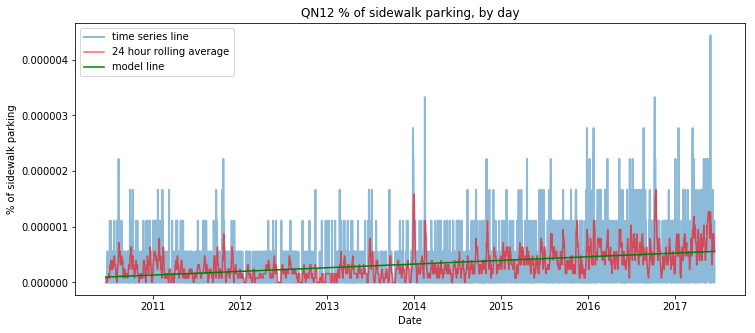

Community District:  QN12
Ratio =  0.176366843034
fitted model coefficient =  1.79674191664e-10
fitted model coefficient 95% confidence interval:  1.68609566675e-10 1.90738816652e-10
R-squared of fitted model =  0.283938846007




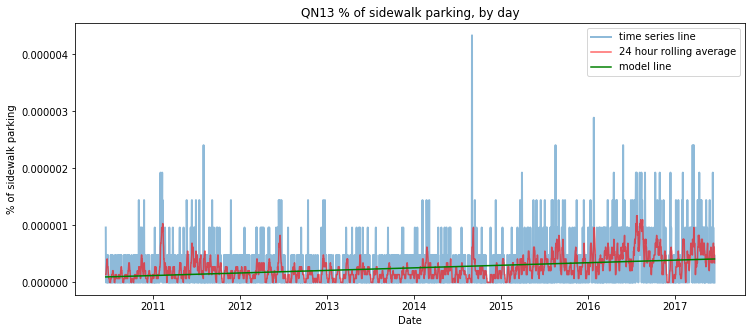

Community District:  QN13
Ratio =  0.31746031746
fitted model coefficient =  1.23152115026e-10
fitted model coefficient 95% confidence interval:  1.13670238212e-10 1.32633991841e-10
R-squared of fitted model =  0.202342935247




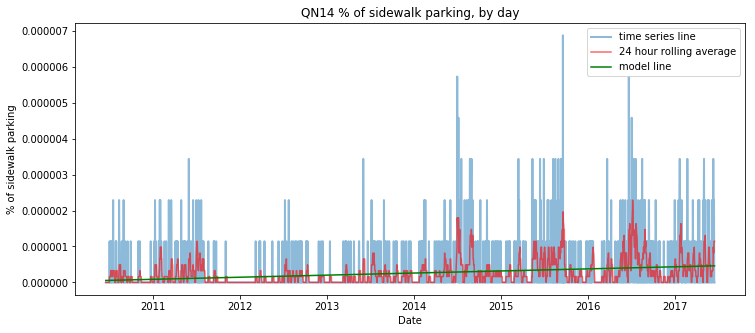

Community District:  QN14
Ratio =  0.0952380952381
fitted model coefficient =  1.58705860144e-10
fitted model coefficient 95% confidence interval:  1.42885608059e-10 1.7452611223e-10
R-squared of fitted model =  0.131442129138




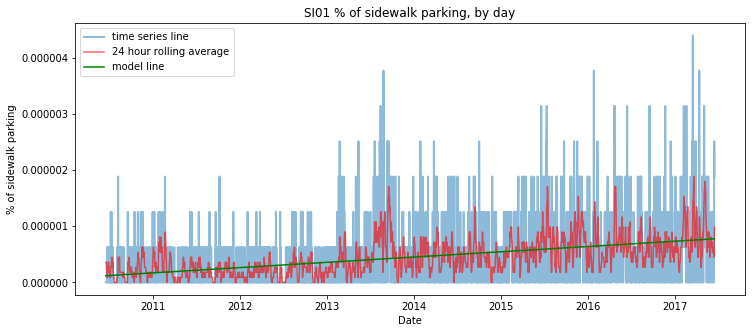

Community District:  SI01
Ratio =  0.207039337474
fitted model coefficient =  2.56731197421e-10
fitted model coefficient 95% confidence interval:  2.43265507989e-10 2.70196886854e-10
R-squared of fitted model =  0.353424181549




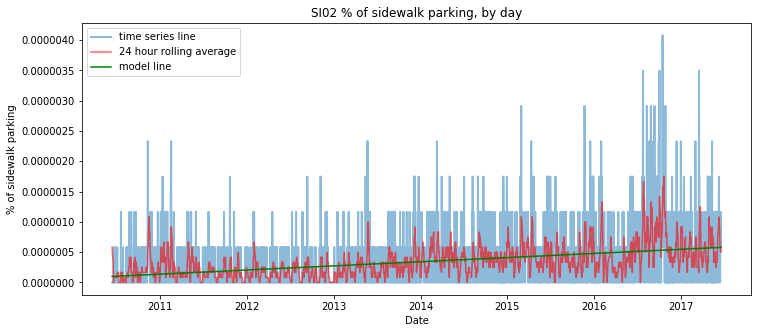

Community District:  SI02
Ratio =  0.0761904761905
fitted model coefficient =  1.87407965816e-10
fitted model coefficient 95% confidence interval:  1.75890149859e-10 1.98925781773e-10
R-squared of fitted model =  0.284753121134




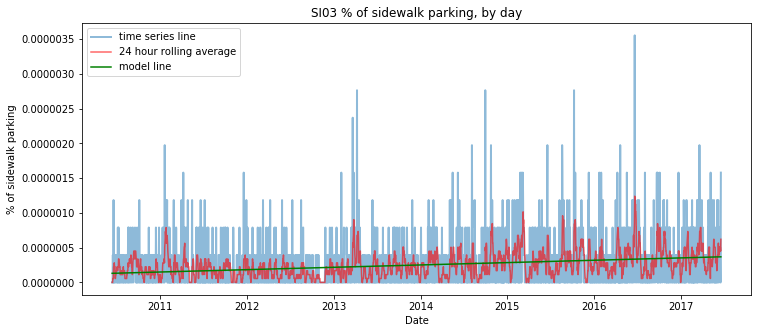

Community District:  SI03
Ratio =  0.362811791383
fitted model coefficient =  9.27114544121e-11
fitted model coefficient 95% confidence interval:  8.40719284051e-11 1.01350980419e-10
R-squared of fitted model =  0.14760600751




In [110]:
#for each ridetype, plot time series
increase_trend = []
decrease_trend = []
stationary_trend = []
for i in nypd_cd_acs_df.cd_id.unique():
    #fit linear regression to time series models
    df = nypd_cd_acs_df[nypd_cd_acs_df.cd_id==i]
    #aggregate to daily level
    df['day'] = df.day_hour.apply(lambda x: x.date())
    df = df.groupby(['day'], as_index=False)['pct_sidewalk_parking'].mean()
    #weekly rolling mean
    df['rolling_mean'] = pd.rolling_mean(df.pct_sidewalk_parking, 7)
    df['day_number'] = df.index
    results = smf.ols(formula = 'rolling_mean ~ day_number', data=df).fit()
    df = df.dropna()
    plt.figure(figsize=(12,5))
    plt.plot(df.day, df.pct_sidewalk_parking, linewidth=2.0, label='time series line', alpha=0.5)
    plt.plot(df.day, df.rolling_mean, c='r', label='24 hour rolling average', alpha=0.6)
    plt.plot(df.day, results.predict(), c='g', label='model line')
    plt.xlabel('Date')
    plt.ylabel('% of sidewalk parking')
    plt.title(i + ' % of sidewalk parking, by day')
    plt.legend()
    results.conf_int(alpha=0.05)[1:]
    plt.show()
    #ticket change of first three weeks divided by last three weeks
    try:
        ticket_change = df['pct_sidewalk_parking'].iloc[0:21].mean() / df['pct_sidewalk_parking'].iloc[-21:-1].mean()
    except:
        ticket_change = 0
    
    print 'Community District: ', i
    print 'Ratio = ', ticket_change
    print 'fitted model coefficient = ', results.params[1]
    print 'fitted model coefficient 95% confidence interval: ', results.conf_int(alpha=0.05)[1:][0][0], results.conf_int(alpha=0.05)[1:][1][0]
    print 'R-squared of fitted model = ', results.rsquared
    print '\n'
    '''
    #if the resulting fitted model has an r-squared above .6 and a 95% confidence interval positive and not including zero then increasing!
    if (results.conf_int(alpha=0.05)[1:][0][0] > 0) and (results.rsquared > 0.6):
        print(ridetype[i] + ' exhibits an increasing trend in popularity from May 2010 to Feb 2014.')
        print('This is due to the fitted model r-squared being above .6 \n(meaning it is not a changing structure, it is an actual trend)')
        print('and the fact that the 95% confidence interval for the \ncoefficient of the fitted model line is positive and does not include zero.')
        increase_trend.append(ridetype[i])
    elif (results.conf_int(alpha=0.05)[1:][1][0] < 0) and (results.rsquared > 0.6):
    #if the resulting fitted model has an r-squared above .6 and a 95% confidence interval negative and not including zero then decreasing!    
        print(ridetype[i] + ' exhibits a decreasing trend in popularity from May 2010 to Feb 2014.')
        print('This is due to the fitted model r-squared being above .6 \n(meaning it is not a changing structure, it is an actual trend)')
        print('and the fact that the 95% confidence interval for the \ncoefficient of the fitted model line is negative and does not include zero.')        
        decrease_trend.append(ridetype[i])
    else:
        print(ridetype[i] + ' exhibits either a stationary trend in popularity \nfrom May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.')
        stationary_trend.append(ridetype[i])      
    '''

# read in community district shapefile